In [72]:
# using Pkg
# Pkg.activate("")

# # Packages that you need
# packages_to_install = ["MLDatasets", "Plots", "Statistics", "Distributions", "Random", "Flux", "Yao", "FLOYao", "PythonCall", "BenchmarkTools", "Dates", "FiniteDifferences"]

# for pkg in packages_to_install
#     Pkg.add(pkg)
# end

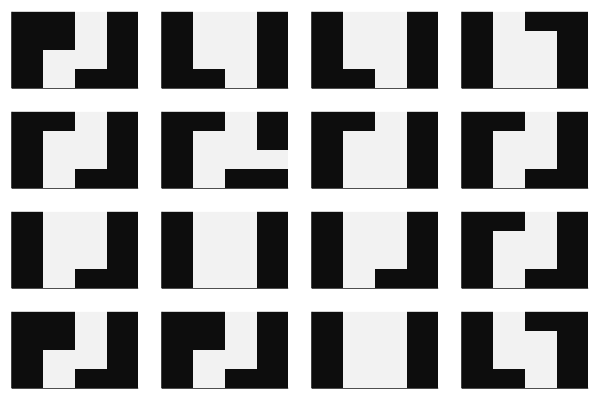

In [73]:
using MLDatasets
using Plots
using Statistics
using Distributions
using Random

train = 16 # Size of training dataset

digit = 1 # Digit to be learned
image_size = 28 # Size of image
compress_size = 4 # Size of compressed image

function compress(img, original, compress, max = true) #If max is false, then it does mean-convolution instead
    ratio = original ÷ compress
    compressed = zeros(compress, compress)
    a = []
    for i in 0:compress-1
        for j in 0:compress-1
            empty!(a)
            for p in 1:ratio
                for q in 1:ratio
                    push!(a, img[(ratio*i) + p, (ratio*j) + q])
                end
            end
            compressed[i+1, j+1] = max ? maximum(a) : mean(a)
        end
    end
    return compressed
end

train_set = MNIST(:train)
train_labels = MNIST(split=:train).targets

data_train = []
c = 1
trainstats = []
for _ in 1:train
    while train_labels[c] != digit
        c += 1
    end
    push!(data_train, compress(rotl90(train_set[c][1]), image_size, compress_size) .> 0.5)
    push!(trainstats, sum(compress(train_set[c][1], image_size, compress_size) .> 0.5))
    c += 1
end

plot([heatmap(x, color=:grays, colorbar = false, ticks = false) for x in data_train]...) #Is there any way to make this look nicer? use pythoncall and matplotlib i guess

In [74]:
using Yao
using Flux

N = compress_size^2 #Number of qubits

f = Chain(Dense(N, 10, relu), Dense(10, 1, sigmoid))

nparams = sum(length, Flux.params(f))
println("Number of parameters in critic: $nparams")

layers = 5
g = chain(N)
for _ in 1:layers
    for i in 1:N-1
        push!(g, rot(kron(N, i => X, i+1 => X), 0.)) #Implemented using qiskit's definition (https://qiskit.org/documentation/stubs/qiskit.circuit.library.RXXGate.html)
    end
    for i in 1:N-1
        push!(g, rot(kron(N, i => X, i+1 => Y), 0.))
    end
    # for i in 1:N-1
    #     push!(g, rot(kron(N, i => Y, i+1 => Y), 0.))
    # end
    # Not needed YY = XX and IZ and ZI
    for i in 1:N
        push!(g, put(N, i => Rz(0.)))
    end
end
#To enhance expressibility:
# Change circuit ansatz to include more generators
# Change pprior() to become nonconstant
# Gradient doesn't change if you sample from a nonconstant distribution of states? As opposed to all zero state
# Can prove this analytically
# Run on GPU?

nparams = nparameters(g)
println("Number of parameters in generator: $nparams")  
#dispatch!(g, :random)
dispatch!(g, rand(nparams).*2π);

Number of parameters in critic: 181


Number of parameters in generator: 230


μ: 6.5
σ: 0.9660917830792959
Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

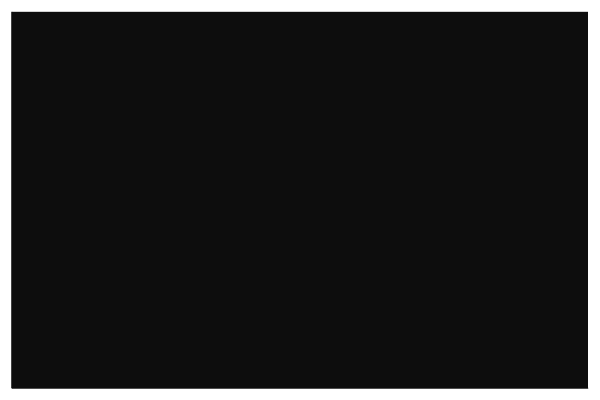

In [75]:
using FLOYao
using Random
using Distributions

mu = mean(trainstats)
sigma = std(trainstats)
println("μ: $mu")
println("σ: $sigma")
#dist = Normal(mu, sigma/20)
dist = Normal(mu, 1)

#ratio = rand(dist) / N
ratio = 0 #if ratio = 0 then pprior() is all 0s
function pprior() #For each square, probability ratio that it's white, where ratio ~ N(mean(data), std(data)) /  N; maybe we can vary pprior later?
    a = rand(N) .< ratio
    return FLOYao.product_state(Int.(a)) #Returns MajoranaReg; Prepares it to be sent through the generator 
end

pprior_example = rand(N) .< ratio
print(pprior_example)
heatmap(rotl90(reshape(pprior_example, compress_size, compress_size)) .> 0.5, color=:grays, colorbar = false, ticks = false)

In [76]:
using Flux: train!
using Yao
using FLOYao
using Statistics

function postprocess(g_output::Vector) #turns the output of reg |> g |> measure into an Int vector
    result = []
    for i in 1:N 
        push!(result, g_output[1][end - i + 1])
    end
    Int.(result)
end

samplemean_batch = 100 #This doesn't need to be that big
dispatch!(g, rand(nparams).*2π)
function run_g(; theta = parameters(g), nbatch = samplemean_batch)
    dispatch!(g, theta)
    samples = []
    for i in 1:nbatch
        z = pprior() #MajoranaReg object
        result = z |> g |> measure |> postprocess
        if i == 1
            samples = result
        else
            samples = hcat(samples, result) #is this operation slow; on another note there has to be a better way to write this function right
        end
    end
    samples
end
#outputs an N * #samples matrix

function run_d_fake(samples)
    if size(samples)[1] != N #Require samples to be an N x #samples matrix
        println("Improper formatting of samples")
        return
    end
    samples |> d
end

function run_d_real() #Runs d on all training data
    samples = []
    for i in 1:train
        result = data_train[i] |> vec
        if i == 1
            samples = result
        else
            samples = hcat(samples, result)
        end
    end
    samples |> d
end

function gLoss(; theta = parameters(g), nbatch = samplemean_batch)
    mean(f(run_g(theta = theta, nbatch = nbatch)))
end

function clip(x, threshold) #x is the input, clips x to be in [-threshold, threshold]
    if x < -threshold
        return -threshold
    elseif x > threshold
        return threshold
    end
    return x
end

function clip_weights(model, threshold) #Clips all weights of Flux model
    for i in 1:length(Flux.params(model))
        if i % 2 == 1
            Flux.params(model)[i] .= clip.(Flux.params(model)[i], threshold)
        end
    end
end

function criticLoss(model, real, fake)
    model(real) - model(fake)
end

function pred_WassersteinDist(model, real, fake) #Doesn't really work because Lipschitz constraint is not strictly enforced; clipping weights only guarantees that |f|_L ≤ K for some K, which is enough
    -critic_loss(model, real, fake)
end

pred_WassersteinDist (generic function with 1 method)

In [77]:
using Yao
using FLOYao

function parametershift_grad(theta = parameters(g)) #Shift parameters in-place
    l = nparameters(g)
    temp_params = theta
    temp_params[1] += π/2
    grad = zeros(l)
    for i in 1:l
        plus = 0
        minus = 0
        dispatch!(g, temp_params)
        plus = gLoss() #This is the problem
        temp_params[i] -= π
        dispatch!(g, temp_params)
        minus = gLoss()
        grad[i] = (plus - minus) / 2
        if i < l
            temp_params[i] += π/2
            temp_params[i+1] += π/2
        end
    end
    temp_params[l] += π/2
    dispatch!(g, temp_params)
    grad
end

#println(finitediff_grad())
#Computing gradients is slow and also I'm still getting different results for parametershift and finitediff
#parametershift prints very small numbers and finitediff prints very big numbers...

# for _ in 1:10
#     println(parametershift_grad()) #Should print similar numbers...
# end

parametershift_grad (generic function with 2 methods)

In [95]:
g_lr = 1e-3 #Usually is like 10^{-3} to 10^{-4}
alpha = 0.00005
c = 0.01
n_critic = 5

opt = Flux.setup(RMSProp(alpha), f)

gLoss_vals = []
criticLoss_vals = []
mean_grads = []
g_params = []
critic_params = []
#Keep track of avg discriminator output on real vs. fake data and make sure none of them gets too small or too large
epochs = 5
batch = train

function trainG() #Does gradient descent on G, then saves its loss in gLoss_vals
    ∇ = parametershift_grad()
    push!(mean_grads, mean(∇))
    dispatch!(-, g, ∇ * g_lr)
    push!(gLoss_vals, gLoss())
end

function trainCritic() #Does one RMSProp step on critic, then saves its loss in criticLoss_vals
    real = []
    fake = []
    for m in 1:batch
        x = data_train[m] |> vec 
        push!(real, Int.(x))
        push!(fake, run_g(nbatch = 1)) #Find a better way to preprocess real and fake data...
    end
    data = collect(zip(real, fake)) 
    Flux.train!(criticLoss, f, data, opt)
    clip_weights(f, c)
    s = 0
    for x in data
        s += criticLoss(f, x[1], x[2])        
    end
    push!(criticLoss_vals, s / batch)
end

function saveParams()
    push!(g_params, parameters(g))
    push!(critic_params, Flux.params(f))
end

for i in 1:epochs #Training loop
    t = time()
    for n in 1:n_critic
        trainCritic()
    end
    trainG()
    saveParams()
    println("iteration $i done in: ", time() - t)
end

g_epochs = 20
#last g_epochs of training for the generator, because we want g to be good, don't really care about d
for q in 1:g_epochs
    t = time()
    trainG()
    push!(g_params, parameters(g))
    println("iteration $q of additional training done in: ", time() - t)
end

hi


hi
Float32[0.50033146]
iteration 1 done in: 

7.7181360721588135


iteration 2 done in: 7.309851884841919
iteration 3 done in: 

7.381792068481445


InterruptException: InterruptException:

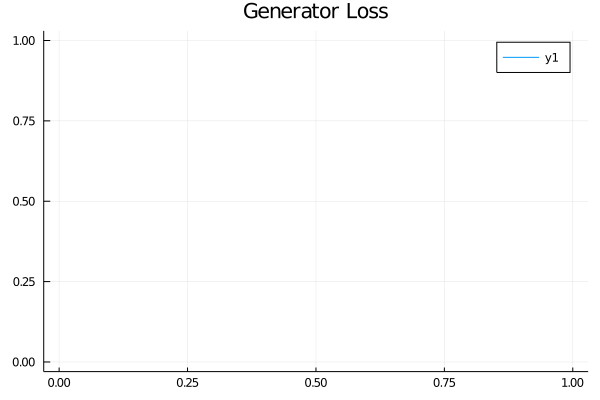

In [79]:
plot(gLoss_vals, title = "Generator Loss", linewidth=3)

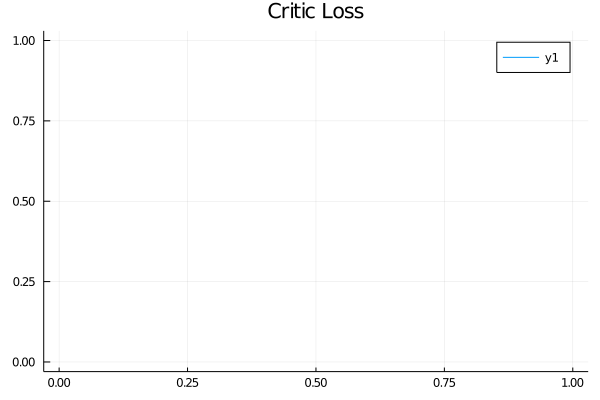

In [80]:
plot(criticLoss_vals, title = "Critic Loss", linewidth=3)

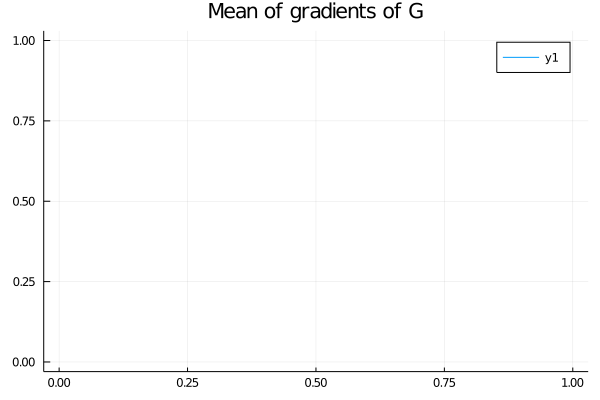

In [81]:
plot(mean_grads, title = "Mean of gradients of G", linewidth=3)

In [82]:
#Testing the Critic

real = []
fake = []
for m in 1:batch
    x = data_train[m] |> vec 
    push!(real, Int.(x))
    push!(fake, run_g(nbatch = 1)) #Find a better way to preprocess real and fake data...
end
println("predicted distance between fake and real data: ", criticLoss(f, real, fake)) #Should print a number close to 0

MethodError: MethodError: no method matching +(::Vector{Float32}, ::Float32)
For element-wise addition, use broadcasting with dot syntax: array .+ scalar

Closest candidates are:
  +(::Any, ::Any, !Matched::Any, !Matched::Any...)
   @ Base operators.jl:578
  +(!Matched::T, ::T) where T<:Union{Float16, Float32, Float64}
   @ Base float.jl:408
  +(!Matched::Union{InitialValues.NonspecificInitialValue, InitialValues.SpecificInitialValue{typeof(+)}}, ::Any)
   @ InitialValues ~/.julia/packages/InitialValues/OWP8V/src/InitialValues.jl:154
  ...


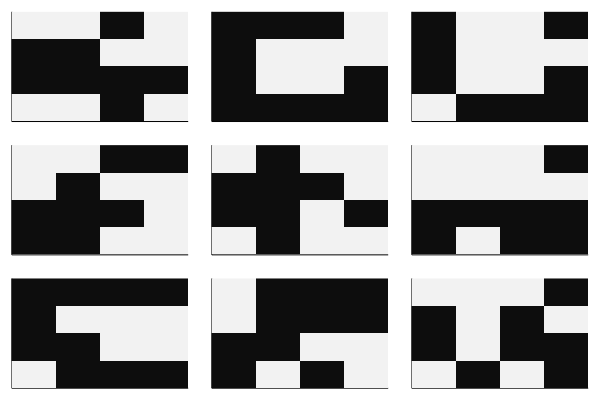

In [83]:
#Testing the Generator

nsamples = 9
samples = run_g(nbatch = nsamples)
plot([heatmap(reshape(samples[:, i], compress_size, compress_size), color=:grays, colorbar = false, ticks = false) for i in 1:nsamples]...)